## Aluno: Davi Segundo Pinheiro - 417153

### Libs utilizadas na Lista 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Carregando os Dados

In [2]:
# Leitura dos dados
dados = np.genfromtxt('./breastcancer.csv', delimiter=',')

# 2 primeiros dados do arquivo
dados[:2]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01,
        0.000e+00],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02,
        0.000e+00]])

In [3]:
# Formato total dos nossos dados
dados.shape

(569, 31)

### Funções Auxiliares

In [4]:
# Escalona os dados de X do treino e do teste
def escalona(x_train, x_teste):    
    x_escalado_treino = x_train
    x_media = x_escalado_treino.mean(axis=0)
    x_desvio = x_escalado_treino.std(axis=0)
    x_escalado_treino = (x_escalado_treino - x_media) / x_desvio
    x_treino = np.c_[np.ones(x_escalado_treino.shape[0]), x_escalado_treino]
    
    x_escalado_teste = x_test
    x_escalado_teste = (x_escalado_teste - x_media) / x_desvio
    x_teste = np.c_[np.ones(x_escalado_teste.shape[0]), x_escalado_teste]
    
    return x_treino, x_teste

# Calula as métricas a partir das funções de cada uma que foram implementadas a abaixo
def calcular_metricas(y_teste, pred):
    accuracy = acuracia(y_teste, pred) * 100
    recall = revocacao(y_teste, pred) * 100
    precision = precisao(y_teste, pred) * 100
    f1 = f1score(recall/100, precision/100) * 100
    
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"F1-Score: {f1:.2f}%\n")
    
    return accuracy, recall, precision, f1

# Calcula as medias de cada métrica
def calcular_medias(accuracy_list, recall_list, precision_list, f1_score_list):
    accuracy_list = np.array(accuracy_list)
    recall_list = np.array(recall_list)
    precision_list = np.array(precision_list)
    f1_score_list = np.array(f1_score_list)

    # Accuracy
    media_accuracy = accuracy_list.mean()
    std_accuracy = accuracy_list.std()
    print(f"Média Accuracy:  {media_accuracy:.2f}%")
    print(f"Desvio Accuracy: {std_accuracy:.2f}%\n")

    # Recall
    media_recall = recall_list.mean()
    std_recall = recall_list.std()
    print(f"Média Recall:  {media_recall:.2f}%")
    print(f"Desvio Recall: {std_recall:.2f}%\n")

    # Precision
    media_precision = precision_list.mean()
    std_precision = precision_list.std()
    print(f"Média Precision:  {media_precision:.2f}%")
    print(f"Desvio Precision: {std_precision:.2f}%\n")

    # F1_Score
    media_f1_score = f1_score_list.mean()
    std_f1_score = f1_score_list.std()
    print(f"Média F1_Score:  {media_f1_score:.2f}%")
    print(f"Desvio F1_Score: {std_f1_score:.2f}%\n")

### Função Sigmoid para classificação

In [5]:
# Definição da função Sigmoid que vai ajustar nosso modelo de classificação
def sigmoid(z):
    sig = 1/(1+np.exp(-z))
    return sig

### Funções para calcular as métricas

In [6]:
def acuracia(y, y_pred):
    acertos = (y == y_pred).sum()
    taxa_acerto = (acertos / y.shape[0])
    return taxa_acerto

def revocacao(y, y_pred):
    verdadeiros_positivos = np.argwhere((y == 1) & (y_pred == 1))[:, 0]
    falsos_negativos = np.argwhere((y == 1) & (y_pred == 0))[:, 0]
    revoc = (len(verdadeiros_positivos)/(len(verdadeiros_positivos) + len(falsos_negativos)))
    return revoc

def precisao(y, y_pred):
    verdadeiros_positivos = np.argwhere((y == 1) & (y_pred == 1))[:, 0]
    falsos_positivos = np.argwhere((y == 0) & (y_pred == 1))[:, 0]
    precision = (len(verdadeiros_positivos)/(len(verdadeiros_positivos) + len(falsos_positivos)))
    return precision

def f1score(revoc, precision):
    f1 = (2 * ((revoc*precision)/(revoc+precision)))
    return f1

### KFold de 10 splits & Separação do X e y

In [7]:
np.random.seed(42)

# Criando um KFold de 10 splits com shuffle
kf = KFold(n_splits=10, shuffle=True)

# Separação X e y
x = dados[:,:-1]
y = dados[:,[-1]]

### Regressão Logística (Treinado com GD)

In [8]:
accuracy_list_rl = list()
recall_list_rl = list()
precision_list_rl = list()
f1_score_list_rl = list()

fold = 0

for train_index, test_index in kf.split(x):
    fold += 1
    print(f"----- Fold {fold} -----")
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    x_treino, x_teste = escalona(x_train, x_test)
    
    y_treino = y_train
    y_teste = y_test
    
    n = x_treino.shape[0]

    alpha = 0.1
    epocas = 200
    
    w = np.zeros((x_treino.shape[1], 1))
    
    mse_lista = list()
    
    for epoca in range(epocas):
        error = y_treino - sigmoid(x_treino @ w)
        w += alpha * x_treino.T @ error / n
    
        mse = np.mean((y_treino - sigmoid(x_treino @ w)) ** 2)
        mse_lista.append(mse)
        
    pred_treino = sigmoid(x_treino @ w)
    pred = sigmoid(x_teste @ w)
    
    pred_treino = np.round(pred_treino)
    pred = np.round(pred)
    
    mse_treino = (np.mean((y_treino - pred_treino)**2))
    mse_teste = (np.mean((y_teste - pred)**2))
    
    accuracy, recall, precision, f1 = calcular_metricas(y_teste, pred)
    
    accuracy_list_rl.append(accuracy)
    recall_list_rl.append(recall)
    precision_list_rl.append(precision)
    f1_score_list_rl.append(f1)

----- Fold 1 -----
Accuracy: 98.25%
Recall: 100.00%
Precision: 97.56%
F1-Score: 98.77%

----- Fold 2 -----
Accuracy: 100.00%
Recall: 100.00%
Precision: 100.00%
F1-Score: 100.00%

----- Fold 3 -----
Accuracy: 100.00%
Recall: 100.00%
Precision: 100.00%
F1-Score: 100.00%

----- Fold 4 -----
Accuracy: 98.25%
Recall: 97.50%
Precision: 100.00%
F1-Score: 98.73%

----- Fold 5 -----
Accuracy: 98.25%
Recall: 100.00%
Precision: 97.50%
F1-Score: 98.73%

----- Fold 6 -----
Accuracy: 96.49%
Recall: 100.00%
Precision: 94.12%
F1-Score: 96.97%

----- Fold 7 -----
Accuracy: 98.25%
Recall: 100.00%
Precision: 97.56%
F1-Score: 98.77%

----- Fold 8 -----
Accuracy: 96.49%
Recall: 100.00%
Precision: 93.94%
F1-Score: 96.87%

----- Fold 9 -----
Accuracy: 96.49%
Recall: 100.00%
Precision: 93.75%
F1-Score: 96.77%

----- Fold 10 -----
Accuracy: 96.43%
Recall: 97.30%
Precision: 97.30%
F1-Score: 97.30%



#### Métricas da Regressão Logística

In [9]:
calcular_medias(accuracy_list_rl, 
                recall_list_rl, 
                precision_list_rl, 
                f1_score_list_rl)

Média Accuracy:  97.89%
Desvio Accuracy: 1.32%

Média Recall:  99.48%
Desvio Recall: 1.04%

Média Precision:  97.17%
Desvio Precision: 2.36%

Média F1_Score:  98.29%
Desvio F1_Score: 1.17%



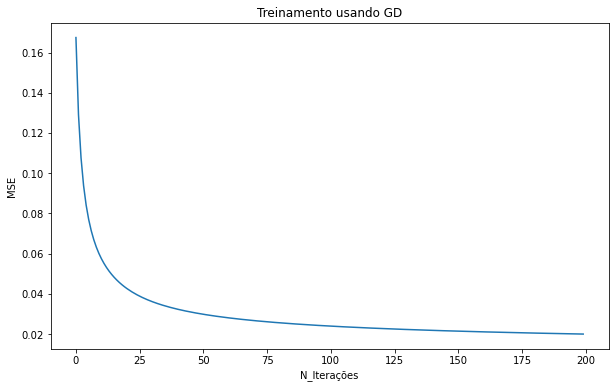

In [10]:
plt.figure(figsize=(10,6))
plt.plot(mse_lista)
plt.ylabel("MSE")
plt.xlabel("N_Iterações")
plt.title("Treinamento usando GD");

### KNN ( $K = 3$ e $distância =  Euclidiana$ )

In [11]:
np.random.seed(42)
fold = 0

accuracy_list_knn = list()
recall_list_knn = list()
precision_list_knn = list()
f1_score_list_knn = list()

k_prox = 3

for train_index, test_index in kf.split(x):
    fold += 1
    print(f"----- Fold {fold} -----")
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    x_treino, x_teste = escalona(x_train, x_test)
    
    y_treino = y_train
    y_teste = y_test
    
    dist2 = -2 * x_teste @ x_treino.T + (x_teste**2).sum(axis=1, keepdims=True) + (x_treino**2).sum(axis=1)
    
    vizinhos = np.argsort(dist2, axis=1)
    vizinhos = vizinhos[:, :k_prox]
    
    classes_vizinhos = y_treino[vizinhos]
    
    pred = classes_vizinhos.mean(axis=1).round()
    
    accuracy, recall, precision, f1 = calcular_metricas(y_teste, pred)
    
    accuracy_list_knn.append(accuracy)
    recall_list_knn.append(recall)
    precision_list_knn.append(precision)
    f1_score_list_knn.append(f1)

----- Fold 1 -----
Accuracy: 92.98%
Recall: 95.00%
Precision: 95.00%
F1-Score: 95.00%

----- Fold 2 -----
Accuracy: 98.25%
Recall: 100.00%
Precision: 96.88%
F1-Score: 98.41%

----- Fold 3 -----
Accuracy: 98.25%
Recall: 100.00%
Precision: 97.37%
F1-Score: 98.67%

----- Fold 4 -----
Accuracy: 98.25%
Recall: 100.00%
Precision: 97.56%
F1-Score: 98.77%

----- Fold 5 -----
Accuracy: 96.49%
Recall: 100.00%
Precision: 95.12%
F1-Score: 97.50%

----- Fold 6 -----
Accuracy: 94.74%
Recall: 100.00%
Precision: 91.43%
F1-Score: 95.52%

----- Fold 7 -----
Accuracy: 98.25%
Recall: 100.00%
Precision: 97.56%
F1-Score: 98.77%

----- Fold 8 -----
Accuracy: 98.25%
Recall: 100.00%
Precision: 96.88%
F1-Score: 98.41%

----- Fold 9 -----
Accuracy: 94.74%
Recall: 96.67%
Precision: 93.55%
F1-Score: 95.08%

----- Fold 10 -----
Accuracy: 92.86%
Recall: 100.00%
Precision: 90.24%
F1-Score: 94.87%



#### Métricas do KNN

In [12]:
calcular_medias(accuracy_list_knn, 
                recall_list_knn, 
                precision_list_knn, 
                f1_score_list_knn)

Média Accuracy:  96.30%
Desvio Accuracy: 2.16%

Média Recall:  99.17%
Desvio Recall: 1.71%

Média Precision:  95.16%
Desvio Precision: 2.51%

Média F1_Score:  97.10%
Desvio F1_Score: 1.66%



### Árvore de Decisão ( $índice de impureza = gini$ )

In [13]:
np.random.seed(42)
fold = 0

accuracy_list_decision_tree = list()
recall_list_decision_tree = list()
precision_list_decision_tree = list()
f1_score_list_decision_tree = list()

model = DecisionTreeClassifier(criterion='gini')

for train_index, test_index in kf.split(x):
    fold += 1
    print(f"----- Fold {fold} -----")
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    x_treino, x_teste = escalona(x_train, x_test)
    
    y_treino = y_train
    y_teste = y_test
    
    # Treino e Predição
    model.fit(x_treino, y_treino)
    pred = model.predict(x_teste)
    
    # Métricas
    accuracy = accuracy_score(y_teste, pred) * 100
    recall = recall_score(y_teste, pred) * 100
    precision = precision_score(y_teste, pred) * 100
    f1 = f1_score(y_teste, pred) * 100
    
    accuracy_list_decision_tree.append(accuracy)
    recall_list_decision_tree.append(recall)
    precision_list_decision_tree.append(precision)
    f1_score_list_decision_tree.append(f1)
    
    print(f"Accuracy:  {accuracy:.2f}%")
    print(f"Recall:    {recall:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"F1_Score:  {f1:.2f}%\n")

----- Fold 1 -----
Accuracy:  92.98%
Recall:    92.50%
Precision: 97.37%
F1_Score:  94.87%

----- Fold 2 -----
Accuracy:  92.98%
Recall:    90.32%
Precision: 96.55%
F1_Score:  93.33%

----- Fold 3 -----
Accuracy:  96.49%
Recall:    94.59%
Precision: 100.00%
F1_Score:  97.22%

----- Fold 4 -----
Accuracy:  87.72%
Recall:    90.00%
Precision: 92.31%
F1_Score:  91.14%

----- Fold 5 -----
Accuracy:  91.23%
Recall:    94.87%
Precision: 92.50%
F1_Score:  93.67%

----- Fold 6 -----
Accuracy:  87.72%
Recall:    87.50%
Precision: 90.32%
F1_Score:  88.89%

----- Fold 7 -----
Accuracy:  98.25%
Recall:    97.50%
Precision: 100.00%
F1_Score:  98.73%

----- Fold 8 -----
Accuracy:  96.49%
Recall:    96.77%
Precision: 96.77%
F1_Score:  96.77%

----- Fold 9 -----
Accuracy:  94.74%
Recall:    96.67%
Precision: 93.55%
F1_Score:  95.08%

----- Fold 10 -----
Accuracy:  92.86%
Recall:    94.59%
Precision: 94.59%
F1_Score:  94.59%



#### Métricas da Árvore de Decisão

In [14]:
calcular_medias(accuracy_list_decision_tree, 
                recall_list_decision_tree, 
                precision_list_decision_tree, 
                f1_score_list_decision_tree)

Média Accuracy:  93.15%
Desvio Accuracy: 3.37%

Média Recall:  93.53%
Desvio Recall: 3.17%

Média Precision:  95.40%
Desvio Precision: 3.12%

Média F1_Score:  94.43%
Desvio F1_Score: 2.75%

